### Initial Setup

In [1]:
# Install
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Import
import os 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile 
from skimage import io 
from torch.utils.data import Dataset
import torch 
import pandas as pd 
from torchvision import transforms
import copy
from sklearn.metrics import mean_squared_error

In [3]:
# System Check
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [4]:
# Find GPU
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
# Reserve GPU
if IN_CADE:
    define_gpu_to_use()

Chosen GPU: 0


### Load and Visualize Dataset

In [6]:
# Opens zip file and places data in datsets folder
def open_zip(filename):
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()

In [7]:
# Return indexes to split data by for train, val, and test
# Splits are 70% train, 10% val, 20% test
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [8]:
# Dataset class for Truss (Bracket/Beam) dataset
class TrussDataset(Dataset):
    def __init__(self, csv_file, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        # Get the split
        all_attributes_frame = pd.read_csv(root_dir + csv_file)
        ids = get_split(pd.unique(all_attributes_frame['ID']), split)
        self.attributes_frame = all_attributes_frame[all_attributes_frame['ID'].isin(ids)]
              
    def __len__(self):
        return len(self.attributes_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.attributes_frame.iloc[idx, 1])
        image = io.imread(image_name)
        image = image.astype(np.float32)
        image = image[:,:,:3]
        image = image/255
        image = np.swapaxes(image, 0, 1)
        image = np.swapaxes(image, 0, 2)
        attributes = self.attributes_frame.iloc[idx, 2:].values
        attributes = attributes.astype('float')
        attribute_names = self.attributes_frame.columns[2:].values
        return torch.FloatTensor(image), torch.FloatTensor(attributes), list(attribute_names)

In [9]:
# Open zip of dataset
open_zip('trussData.zip')

In [10]:
# Create train, val, and test datasets
train_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/')
val_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='val')
test_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='test')

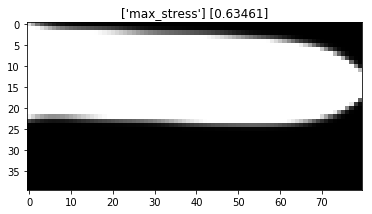

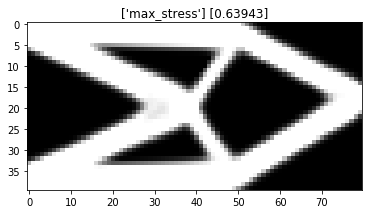

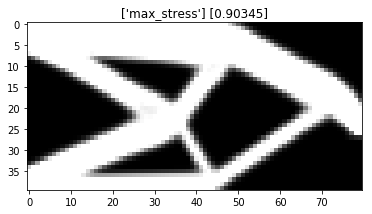

In [11]:
# Visualing a few cases of the training set
for batch_idx, (image, attribute, name) in enumerate(train_dataset):
    if batch_idx%250 == 0: 
        plt.figure()
        plt.title(str(name) + ' ' + str(attribute.cpu().numpy()))
        plt.imshow(image[:,:,:].permute([1, 2, 0]).cpu().numpy())

In [12]:
# Calculates L2 for images and MSE for regression - want both close to 0
def get_score_model(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        distances = []
        mse = []
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, logvar, reg = model(image)
            # Reconstruction Score
            euclidean_dist = torch.pow(torch.sum(torch.pow((image - recon), 2)), 0.5)
            distances.append(euclidean_dist.cpu().numpy())
            # Regression Score
            y_true = attribute.cpu().numpy()
            y_pred = reg.cpu().numpy()         
            mse.append(mean_squared_error(y_true, y_pred))
    
    return np.mean(distances), np.mean(mse)

In [13]:
# Classes to create VAE, ability to change kernel_size of filters for convolution layers
# and the latent representation dim
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        padding = int((kernel_size - 1) / 2)
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.batch = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

class TransBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransBlock, self).__init__()
        self.convT = torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.convT(x)
        return x

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 32, 5, 10) # see if there is a way to not have this hardcoded

In [14]:
# VAE with Regression - The reconstruction and regression are done from the
# latent variables calculated from the reparametrization (distribution)
class VAE_REG(torch.nn.Module):
    def __init__(self, kernel_size, z_dim):
        super(VAE_REG, self).__init__()
        self.encoder = torch.nn.Sequential(
        ConvBlock(in_channels=3, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=8, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=16, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        Flatten()) 
        
        self.mu = torch.nn.Linear(1600, z_dim)
        self.logvar = torch.nn.Linear(1600, z_dim)
        self.fc = torch.nn.Linear(z_dim, 1600)
        
        self.decoder = torch.nn.Sequential(
        UnFlatten(),
        TransBlock(in_channels=32, out_channels=32),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=16, kernel_size=kernel_size),
        TransBlock(in_channels=16, out_channels=16),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=8, kernel_size=kernel_size),
        TransBlock(in_channels=8, out_channels=8),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=3, kernel_size=kernel_size))
        
        self.regression = torch.nn.Sequential(
            torch.nn.Linear(in_features=z_dim, out_features=4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=4, out_features=1))
            
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.FloatTensor(mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, x):
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparametrize(mu, logvar)
        return z, mu, logvar
    
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
    
    def forward(self, x):
        x = self.encoder(x)
        z, mu, logvar = self.bottleneck(x) # z is latent representation
        x = self.fc(z)
        x = torch.sigmoid(self.decoder(x)) # VAE output
        r = self.regression(z) # Regression output
        return x, mu, logvar, r

In [15]:
# Loss function for this task, combines reconstruction and KL for the image task and the MSELoss
# for the regression task
def loss_function(reconstruction, image, mu, logvar, attributes, r, batch_size):
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(reconstruction, image)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /=  batch_size * image.shape[1] * image.shape[2] * image.shape[3]
    reg_loss =  torch.nn.MSELoss()
    return reconstruction_loss, kl_loss, reg_loss(attributes, r)

In [16]:
# VAE conv kernel size = 5 z_dim = 8
BATCH_SIZE = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_loader_score = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#instantiate your model here:
model = VAE_REG(kernel_size=5, z_dim=8)
model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

train_recon_scores = []
train_r2_scores = []
val_recon_scores = []
val_r2_scores = []
target_score = 35.5 # Want score to be less than this
best_score = 50
best_model = copy.deepcopy(model)

print('Starting Training!')
for epoch in range(n_epochs):
    print('\nEpoch: ' + str(epoch))
    scheduler.step()
    
    model.train()
    
    total_losses = []
    reconstruction_losses = []
    kl_losses = []
    reg_losses = []
    for image, attribute, name in train_loader:
        optimizer.zero_grad()
        image = image.cuda()
        attribute = attribute.cuda()
        recon, mu, logvar, reg = model(image)
        reconstruction_loss, kl_loss, reg_loss = loss_function(recon, image, mu, logvar, attribute, reg, BATCH_SIZE)
        loss = reconstruction_loss + kl_loss + reg_loss
        loss.backward()
        optimizer.step()
        
        total_losses.append(loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        kl_losses.append(kl_loss.item())
        reg_losses.append(reg_loss.item())
        
    print('Total Loss: ' + str(np.mean(total_losses)))
    print('Reconstruction Loss: ' + str(np.mean(reconstruction_losses)))
    print('KL Loss: ' + str(np.mean(kl_losses)))
    print('Regression Loss: ' + str(np.mean(reg_losses)))
    
    # Get training data accuracy
    train_recon_score, train_r2 = get_score_model(model, train_loader_score)
    print('Trainig Reconstruction Score: ' + str(train_recon_score))
    print('Training MSE Score: ' + str(train_r2))
    train_recon_scores.append(train_recon_score)
    train_r2_scores.append(train_r2)
    
    # Get validation data accuracy
    val_recon_score, val_r2 = get_score_model(model, val_loader)
    print('Validation Reconstruction Score: ' + str(val_recon_score))
    print('Validation MSE Score: ' + str(val_r2))
    val_recon_scores.append(val_recon_score)
    val_r2_scores.append(val_r2)
    
    # Save Best Model - Based on Reconstruction Score
    if val_recon_score < target_score and val_recon_score < best_score:
        best_score = val_recon_score
        best_model = copy.deepcopy(model)
        print('New Best Model Saved!')

Starting Training!

Epoch: 0
Total Loss: 0.7125790740762438
Reconstruction Loss: 0.6865128908838545
KL Loss: 0.001475663850059001
Regression Loss: 0.02459052278011638
Trainig Reconstruction Score: 44.075832
Training MSE Score: 0.0053551556
Validation Reconstruction Score: 44.267628
Validation MSE Score: 0.0041164327

Epoch: 1
Total Loss: 0.62967158470835
Reconstruction Loss: 0.6225785706724439
KL Loss: 0.0016534122588512089
Regression Loss: 0.005439601979118639
Trainig Reconstruction Score: 41.178726
Training MSE Score: 0.0055621024
Validation Reconstruction Score: 41.43788
Validation MSE Score: 0.0056494894

Epoch: 2
Total Loss: 0.5783961994307382
Reconstruction Loss: 0.5713760273797172
KL Loss: 0.0018888163613155484
Regression Loss: 0.005131357683733638
Trainig Reconstruction Score: 38.96538
Training MSE Score: 0.0048163463
Validation Reconstruction Score: 38.93322
Validation MSE Score: 0.004237454

Epoch: 3
Total Loss: 0.5438340510640826
Reconstruction Loss: 0.5371186741760798
KL Lo

Trainig Reconstruction Score: 33.554615
Training MSE Score: 0.0021601806
Validation Reconstruction Score: 33.821354
Validation MSE Score: 0.003451094

Epoch: 27
Total Loss: 0.4219911055905478
Reconstruction Loss: 0.4167347597224372
KL Loss: 0.0029801037794511234
Regression Loss: 0.0022762410916454556
Trainig Reconstruction Score: 33.538155
Training MSE Score: 0.0020332083
Validation Reconstruction Score: 33.80043
Validation MSE Score: 0.0034234854

Epoch: 28
Total Loss: 0.42136169842311316
Reconstruction Loss: 0.41609030961990356
KL Loss: 0.002975405426695943
Regression Loss: 0.0022959831253891545
Trainig Reconstruction Score: 33.4787
Training MSE Score: 0.0019993968
Validation Reconstruction Score: 33.73658
Validation MSE Score: 0.0031810016
New Best Model Saved!

Epoch: 29
Total Loss: 0.4210292582001005
Reconstruction Loss: 0.4159062594175339
KL Loss: 0.002989831250826163
Regression Loss: 0.0021331684106761324
Trainig Reconstruction Score: 33.536884
Training MSE Score: 0.0022269182
V

Trainig Reconstruction Score: 33.319923
Training MSE Score: 0.0010858206
Validation Reconstruction Score: 33.676857
Validation MSE Score: 0.0035290623

Epoch: 54
Total Loss: 0.4105586068970816
Reconstruction Loss: 0.40630666869027277
KL Loss: 0.0030317638435267977
Regression Loss: 0.0012201747042126954
Trainig Reconstruction Score: 33.232838
Training MSE Score: 0.0012390746
Validation Reconstruction Score: 33.551758
Validation MSE Score: 0.003706227

Epoch: 55
Total Loss: 0.41048951957906993
Reconstruction Loss: 0.40627093613147736
KL Loss: 0.003048611927910575
Regression Loss: 0.0011699719091536412
Trainig Reconstruction Score: 33.20288
Training MSE Score: 0.0011920513
Validation Reconstruction Score: 33.5784
Validation MSE Score: 0.0039516664

Epoch: 56
Total Loss: 0.41015081107616425
Reconstruction Loss: 0.4059388169220516
KL Loss: 0.003052759383405958
Regression Loss: 0.0011592319626028517
Trainig Reconstruction Score: 33.16226
Training MSE Score: 0.0010033143
Validation Reconstruc

Trainig Reconstruction Score: 33.082443
Training MSE Score: 0.00089560205
Validation Reconstruction Score: 33.452553
Validation MSE Score: 0.0038152614

Epoch: 81
Total Loss: 0.40605837404727935
Reconstruction Loss: 0.4021384051867894
KL Loss: 0.0030647702348817673
Regression Loss: 0.0008551962914810117
Trainig Reconstruction Score: 33.05499
Training MSE Score: 0.00066991046
Validation Reconstruction Score: 33.454082
Validation MSE Score: 0.0037546933

Epoch: 82
Total Loss: 0.40575988846165795
Reconstruction Loss: 0.40195947204317367
KL Loss: 0.003051834447043283
Regression Loss: 0.0007485829554622926
Trainig Reconstruction Score: 33.088436
Training MSE Score: 0.00095474866
Validation Reconstruction Score: 33.48732
Validation MSE Score: 0.003867337

Epoch: 83
Total Loss: 0.4057405454771859
Reconstruction Loss: 0.4019512870482036
KL Loss: 0.0030416347618613926
Regression Loss: 0.000747625195279917
Trainig Reconstruction Score: 33.054245
Training MSE Score: 0.0007343499
Validation Recons

Trainig Reconstruction Score: 33.02948
Training MSE Score: 0.00067082845
Validation Reconstruction Score: 33.43573
Validation MSE Score: 0.0034682697

Epoch: 108
Total Loss: 0.4032444553715842
Reconstruction Loss: 0.39957931084292275
KL Loss: 0.003063922348831381
Regression Loss: 0.0006012236542509137
Trainig Reconstruction Score: 32.93971
Training MSE Score: 0.0004673694
Validation Reconstruction Score: 33.4047
Validation MSE Score: 0.0034614655

Epoch: 109
Total Loss: 0.4032158489738192
Reconstruction Loss: 0.3995927768094199
KL Loss: 0.0030651480391887683
Regression Loss: 0.000557924427942323
Trainig Reconstruction Score: 32.962856
Training MSE Score: 0.0006705791
Validation Reconstruction Score: 33.37899
Validation MSE Score: 0.003688093

Epoch: 110
Total Loss: 0.40341013031346457
Reconstruction Loss: 0.39979115554264616
KL Loss: 0.003059356629715434
Regression Loss: 0.0005596196750827533
Trainig Reconstruction Score: 33.035713
Training MSE Score: 0.00056564424
Validation Reconstru

Trainig Reconstruction Score: 32.92934
Training MSE Score: 0.00035345575
Validation Reconstruction Score: 33.364735
Validation MSE Score: 0.0033605844

Epoch: 135
Total Loss: 0.40152876930577414
Reconstruction Loss: 0.3980507071529116
KL Loss: 0.0030694625240617565
Regression Loss: 0.00040859901814006405
Trainig Reconstruction Score: 32.937515
Training MSE Score: 0.00049124745
Validation Reconstruction Score: 33.365524
Validation MSE Score: 0.003425816

Epoch: 136
Total Loss: 0.401399547287396
Reconstruction Loss: 0.397923481464386
KL Loss: 0.0030667568290872233
Regression Loss: 0.00040931060175353196
Trainig Reconstruction Score: 32.892746
Training MSE Score: 0.00046963614
Validation Reconstruction Score: 33.337753
Validation MSE Score: 0.0037131882
New Best Model Saved!

Epoch: 137
Total Loss: 0.40118461549282075
Reconstruction Loss: 0.39770765900611876
KL Loss: 0.0030651080521887967
Regression Loss: 0.0004118491371627897
Trainig Reconstruction Score: 32.941635
Training MSE Score: 0.

Total Loss: 0.39873134536402566
Reconstruction Loss: 0.3954266233103616
KL Loss: 0.0030558047383757573
Regression Loss: 0.0002489152902333964
Trainig Reconstruction Score: 32.806553
Training MSE Score: 0.00022535512
Validation Reconstruction Score: 33.284866
Validation MSE Score: 0.0034130798

Epoch: 162
Total Loss: 0.3986708564417703
Reconstruction Loss: 0.39537675721304755
KL Loss: 0.0030557694312717235
Regression Loss: 0.00023832808114353351
Trainig Reconstruction Score: 32.80241
Training MSE Score: 0.0002323894
Validation Reconstruction Score: 33.294872
Validation MSE Score: 0.0035435306

Epoch: 163
Total Loss: 0.3986139965908868
Reconstruction Loss: 0.39531434774398805
KL Loss: 0.0030548603872635536
Regression Loss: 0.0002447886198102164
Trainig Reconstruction Score: 32.806786
Training MSE Score: 0.00021632241
Validation Reconstruction Score: 33.298714
Validation MSE Score: 0.0034027994

Epoch: 164
Total Loss: 0.3986142303262438
Reconstruction Loss: 0.39533079096249174
KL Loss: 0.

Total Loss: 0.3984225017683847
Reconstruction Loss: 0.3951471652303423
KL Loss: 0.0030570151517167687
Regression Loss: 0.00021832296627378257
Trainig Reconstruction Score: 32.80019
Training MSE Score: 0.0001970524
Validation Reconstruction Score: 33.299946
Validation MSE Score: 0.0035121066

Epoch: 189
Total Loss: 0.3984140834638051
Reconstruction Loss: 0.39514312871864865
KL Loss: 0.00305856519844383
Regression Loss: 0.0002123888896416507
Trainig Reconstruction Score: 32.79627
Training MSE Score: 0.0002004283
Validation Reconstruction Score: 33.28263
Validation MSE Score: 0.0034075372

Epoch: 190
Total Loss: 0.39838015948023114
Reconstruction Loss: 0.3951022488730294
KL Loss: 0.0030567458398374063
Regression Loss: 0.00022116670697869267
Trainig Reconstruction Score: 32.80082
Training MSE Score: 0.00020043827
Validation Reconstruction Score: 33.302406
Validation MSE Score: 0.0035318518

Epoch: 191
Total Loss: 0.3983970378126417
Reconstruction Loss: 0.39512425661087036
KL Loss: 0.003058

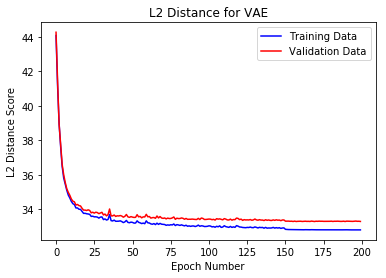

In [17]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_recon_scores, 'b', range(n_epochs), val_recon_scores, 'r')
plt.title('L2 Distance for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('L2 Distance Score')
plt.show()

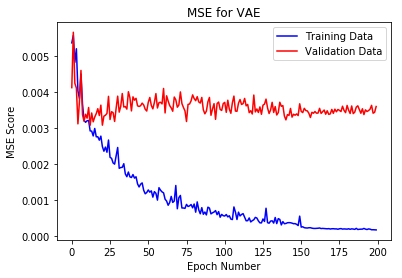

In [18]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_r2_scores, 'b', range(n_epochs), val_r2_scores, 'r')
plt.title('MSE for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('MSE Score')
plt.show()

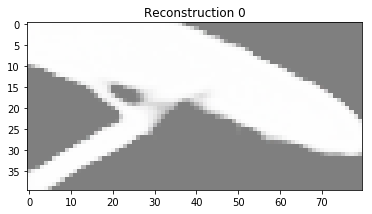

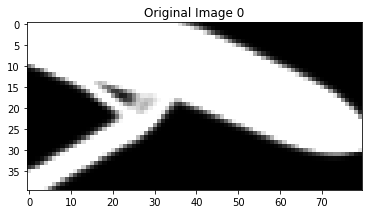

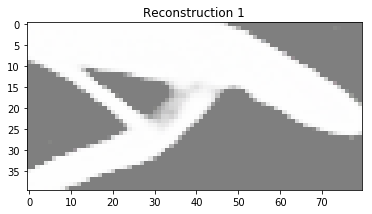

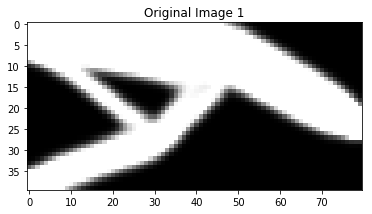

In [19]:
# Show examples of the ground truth image and the reconstruction after
# a pass through the autoencoder
def get_example_outputs(model, data_loader):
    model.eval()
    ground_truth = []
    model_output = []
    with torch.no_grad():
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, var, reg = model(image)
            model_output.append(recon)
            ground_truth.append(image)
            if len(model_output) == 2:
                return model_output, ground_truth
            
model_out, gt = get_example_outputs(model, val_loader)
for idx in range(2):
    plt.figure()
    plt.title("Reconstruction " + str(idx))
    model_out[idx] = model_out[idx].view(model_out[idx].shape[1], model_out[idx].shape[2], model_out[idx].shape[3])
    plt.imshow(model_out[idx].permute([1, 2, 0]).cpu().numpy())
    plt.figure()
    plt.title("Original Image " + str(idx))
    gt[idx] = gt[idx].view(gt[idx].shape[1], gt[idx].shape[2], gt[idx].shape[3])
    plt.imshow(gt[idx].permute([1, 2, 0]).cpu().numpy())

In [20]:
test_recon_score, test_mse_score = get_score_model(best_model, test_loader)
print('Test L2 Score: ' + str(test_recon_score))
print('Test MSE Score: ' + str(test_mse_score))

Test L2 Score: 33.229668
Test MSE Score: 0.003324734
